# Example of recipe computation, model fit, predict* and conversion to raster using API of antares3 and [kale](https://github.com/kubeflow-kale/kale) functionality

*Prediction is pixel wise.

**Will use an already ingested and processed Landsat8 data via antares3**

## Some imports

In [1]:
import sys

import os
import json
from datetime import datetime

import matplotlib
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
from shapely.geometry import Point
import rasterio
import dill
import geopandas as gpd
import fiona
from affine import Affine
from rasterio.features import rasterize


In [2]:
sys.__stdout__ = sys.stdout

In [3]:
import datacube
from datacube.api import GridWorkflow
from datacube.storage import masking
from datacube.drivers.netcdf import write_dataset_to_netcdf

from madmex.util.db import get_cmap_from_scheme
from madmex.models import Tag
from madmex.overlay.extractions import zonal_stats_xarray
from madmex.io.vector_db import VectorDb
from madmex.wrappers import gwf_query
from madmex.modeling.supervised.xgb import Model
from madmex.models import Tag
from madmex.overlay.extractions import zonal_stats_xarray
from madmex.util import randomword, mid_date, join_dicts
from madmex.util.xarray import to_float, to_int
from django.contrib.gis.geos.geometry import GEOSGeometry
from madmex.models import PredictObject

/usr/local/lib/python3.6/dist-packages/dask/utils.py:30: RuntimeWarning: All-NaN slice encountered
2020-09-07 21:08:33,526 - madmex.wrappers - loggerwriter write: /usr/local/lib/python3.6/dist-packages/dask/utils.py:30: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
2020-09-07 21:08:33,528 - madmex.wrappers - loggerwriter write:   return func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
2020-09-07 21:08:36,213 - madmex.wrappers - loggerwriter write: /usr/local/lib/python3.6/dist-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
2020-09-07 21:08:36,214 - madmex.wrappers - loggerwriter write:   ret = f(ret)
/usr/local/lib/python3.6/dist-packages/dask/utils.py:30: RuntimeWarning: All-NaN slice encountered
2020-09-07 21:09:00,635 - madmex.wrappers - loggerwriter write: /usr/local/lib/python3.6/dist-packages/dask/utils.py:30: RuntimeWarning: All-NaN 

In [4]:
sys.stdout = sys.__stdout__

## Recipe computation

Following [landsat_madmex_003.py](https://github.com/CONABIO/antares3/blob/develop/madmex/recipes/landsat_madmex_003.py)

Also could be helpful:

[1c_clusterization_for_agriculture_inecol](https://github.com/CONABIO/antares3-sandbox/blob/master/notebooks/agriculture_madmex_app/1c_clusterization_for_agriculture_inecol.ipynb)


[1d_clusterization_for_agriculture_inecol](https://github.com/CONABIO/antares3-sandbox/blob/master/notebooks/agriculture_madmex_app/1d_clusterization_for_agriculture_inecol.ipynb)

[2_clusterization_for_agriculture_inecol_intersect_with_area_of_interest.](https://github.com/CONABIO/antares3-sandbox/blob/master/notebooks/agriculture_madmex_app/2_clusterization_for_agriculture_inecol_intersect_with_area_of_interest.ipynb)

In [5]:
name_of_recipe_product = 'recipe_chiapas_L8_17'

In [6]:
path_recipe = os.path.join('/shared_volume/datacube_ingest/recipes/', name_of_recipe_product)

In [8]:
print(path_recipe)

/shared_volume/datacube_ingest/recipes/recipe_chiapas_L8_17


In [9]:
if not os.path.exists(path_recipe):
    os.makedirs(path_recipe)

In [10]:
os.environ.setdefault("DJANGO_ALLOW_ASYNC_UNSAFE", "true")

region = 'Chiapas'
products = ['ls8_espa_mexico']
begin = '2017-01-01'
end = '2017-12-31'
gwf_kwargs = {'region': region, 
              'begin': begin, 
              'end':end}


In [11]:
os.environ.setdefault("DJANGO_ALLOW_ASYNC_UNSAFE", "true")

#query

dict_list = []
for prod in products:
    gwf_kwargs.update(product = prod)
    try:
        dict_list.append(gwf_query(**gwf_kwargs, view=False))
    # Exception is in case one of the product hasn't been registered in the datacube
    except Exception as e:
        pass
iterable = join_dicts(*dict_list, join='full').items()


list_iter = list(iterable)

list_iter_sorted = sorted(list_iter, key = lambda x: (x[0][0], x[0][1]))

In [12]:
os.environ.setdefault("DJANGO_ALLOW_ASYNC_UNSAFE", "true")

# Select datacube tile index: (54, -38)

tile = [index for index in list_iter_sorted if index[0] == (54, -38)][0]
center_dt = mid_date(datetime.strptime(begin, '%Y-%m-%d'), 
                     datetime.strptime(end, '%Y-%m-%d'))
crs = tile[1][0].geobox.crs
center_dt = center_dt.strftime("%Y-%m-%d")
nc_filename = os.path.join(path_recipe, 'madmex_003_%d_%d_%s.nc' % (tile[0][0], tile[0][1], center_dt))


In [13]:
print(nc_filename)

/shared_volume/datacube_ingest/recipes/recipe_chiapas_L8_17/madmex_003_54_-38_2017-07-02.nc


In [14]:
os.environ.setdefault("DJANGO_ALLOW_ASYNC_UNSAFE", "true")

# Load via Grid Workflow API
ds = xr.combine_by_coords([GridWorkflow.load(x, dask_chunks={'x': 1200, 'y': 1200})
                             for x in tile[1]], data_vars='minimal', coords='minimal')
ds.attrs['geobox'] = tile[1][0].geobox

# Mask clouds, shadow, water, ice,... and drop qa layer
clear = masking.make_mask(ds.pixel_qa, cloud=False, cloud_shadow=False,
                          snow=False)
ds_1 = ds.where(clear)
ds_1 = ds_1.drop('pixel_qa')
ds_1 = ds_1.apply(func=to_float, keep_attrs=True)
# Compute vegetation indices
ds_1['ndvi'] = ((ds_1.nir - ds_1.red) / (ds_1.nir + ds_1.red)) * 10000
ds_1['ndvi'].attrs['nodata'] = -9999
ds_1['ndmi'] = ((ds_1.nir - ds_1.swir1) / (ds_1.nir + ds_1.swir1)) * 10000
ds_1['ndmi'].attrs['nodata'] = -9999
# Run temporal reductions and rename DataArrays
ds_mean = ds_1.mean('time', keep_attrs=True, skipna=True)
ds_mean = ds_mean.rename({'blue': 'blue_mean',
                          'green': 'green_mean',
                          'red': 'red_mean',
                          'nir': 'nir_mean',
                          'swir1': 'swir1_mean',
                          'swir2': 'swir2_mean',
                          'ndmi': 'ndmi_mean',
                          'ndvi': 'ndvi_mean'})
# Compute min/max/std only for vegetation indices
ndvi_max = ds_1.ndvi.max('time', keep_attrs=True, skipna=True)
ndvi_max = ndvi_max.rename('ndvi_max')
ndvi_max.attrs['nodata'] = -9999
ndvi_min = ds_1.ndvi.min('time', keep_attrs=True, skipna=True)
ndvi_min = ndvi_min.rename('ndvi_min')
ndvi_min.attrs['nodata'] = -9999
# ndmi
ndmi_max = ds_1.ndmi.max('time', keep_attrs=True, skipna=True)
ndmi_max = ndmi_max.rename('ndmi_max')
ndmi_max.attrs['nodata'] = -9999
ndmi_min = ds_1.ndmi.min('time', keep_attrs=True, skipna=True)
ndmi_min = ndmi_min.rename('ndmi_min')
ndmi_min.attrs['nodata'] = -9999
# Load terrain metrics using same spatial parameters than sr
dc = datacube.Datacube(app = 'landsat_madmex_003_%s' % randomword(5))
terrain = dc.load(product='srtm_cgiar_mexico', like=ds,
                  time=(datetime(1970, 1, 1), datetime(2018, 1, 1)),
                  dask_chunks={'x': 1200, 'y': 1200})
dc.close()
# Merge dataarrays
combined = xr.merge([ds_mean.apply(to_int),
                     to_int(ndvi_max),
                     to_int(ndvi_min),
                     to_int(ndmi_max),
                     to_int(ndmi_min),
                     terrain])
combined.attrs['crs'] = crs
#write_dataset_to_netcdf(combined.compute(scheduler='threads'), nc_filename)

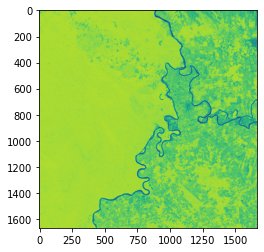

In [15]:
plt.imshow(combined.ndvi_mean[:,:])
plt.show()

## Fit model

## Load data from antares_datacube DB

In [16]:
os.environ.setdefault("DJANGO_ALLOW_ASYNC_UNSAFE", "true")

training_data = "train_chiapas_dummy"

loader = VectorDb()
fc_train_0 = loader.load_training_from_dataset(dataset=combined,
                                               training_set=training_data, 
                                               sample=1)

fc_train_0 = list(fc_train_0)


#Assign code level to this training data according to next scheme...
scheme = "madmex"

qs = Tag.objects.filter(scheme=scheme)
tag_mapping = {x.id:x.numeric_code for x in qs}
tag_id_list = [x['properties']['class'] for x in fc_train_0]

fc_train = [{'geometry': x[0]['geometry'],
             'properties': {'code': tag_mapping[x[1]]},
             'type': 'feature'} for x in zip(fc_train_0, tag_id_list)]



## Extract some zonal statistics using dataset and feature collection of training data...

In [17]:
os.environ.setdefault("DJANGO_ALLOW_ASYNC_UNSAFE", "true")

X_train, y_train = zonal_stats_xarray(combined, fc_train, 'code')

## Write model fit to filesystem

In [18]:
os.environ.setdefault("DJANGO_ALLOW_ASYNC_UNSAFE", "true")


path_result = "/shared_volume/land_cover_results"
if not os.path.exists(path_result):
    os.makedirs(path_result)
xgb_model = Model()
xgb_model.fit(X_train, y_train)
filename_model = 'model_landsat8_chiapas_2017_madmex_31_clases_via_kale' + '_%d_%d' %(tile[0][0],tile[0][1]) + '.pkl'
filepath_model = os.path.join(path_result, filename_model)
with open(filepath_model, 'wb') as dst:
    dill.dump(xgb_model, dst)

## Predict and write raster to FS

In [19]:
os.environ.setdefault("DJANGO_ALLOW_ASYNC_UNSAFE", "true")


arr_3d = combined.to_array().squeeze().values #squeeze to remove time dimension 
                                        #because has length 1
arr_3d = np.moveaxis(arr_3d, 0, 2)

shape_2d = (arr_3d.shape[0] * arr_3d.shape[1], arr_3d.shape[2])

arr_2d = arr_3d.reshape(shape_2d)

predicted_array = xgb_model.predict(arr_2d)

#write to FS

predicted_array = predicted_array.reshape((arr_3d.shape[0], arr_3d.shape[1]))
predicted_array = predicted_array.astype('uint8')

rasterio_meta = {'width': predicted_array.shape[1],
                 'height': predicted_array.shape[0],
                 'transform': ds.affine,
                 'crs': ds.crs.crs_str,
                 'count': 1,
                 'dtype': 'uint8',
                 'compress': 'lzw',
                 'driver': 'GTiff',
                 'nodata': 0}

filename_raster = 'raster_landsat8_chiapas_madmex_31_clases_pixel_wise_via_kale' + '_%d_%d' %(tile[0][0],tile[0][1]) + '.tif'
filename_raster = os.path.join(path_result, filename_raster)


with rasterio.open(filename_raster, 'w', **rasterio_meta) as dst:
    dst.write(predicted_array, indexes = 1)

**Next will use:**

[ingest_recipe_products](https://github.com/CONABIO/antares3-sandbox/blob/master/notebooks/ingest_recipe_products/ingest_recipe_products.ipynb)



**Need to create `/shared_volume/.config/madmex/indexing/`:**

```
mkdir -p /shared_volume/.config/madmex/indexing/
cp ~/.config/madmex/indexing/landsat_madmex_003.yaml /shared_volume/.config/madmex/indexing/
```

In [33]:
from madmex.indexing import add_product_from_yaml, add_dataset, metadict_from_netcdf
from madmex.util import yaml_to_dict

In [34]:
yaml_file = '/shared_volume/.config/madmex/indexing/landsat_madmex_003.yaml' 
recipe = 'landsat_madmex_003'

In [38]:
product_description = yaml_to_dict(yaml_file)
args = {'description': product_description,
        'center_dt': datetime.strptime(center_dt, '%Y-%m-%d'),
        'from_dt': datetime.strptime(begin, '%Y-%m-%d'),
        'to_dt': datetime.strptime(end, '%Y-%m-%d'),
        'algorithm': recipe}

pr, dt = add_product_from_yaml(yaml_file, name_of_recipe_product)

result = metadict_from_netcdf(nc_filename, **args)

print("Adding %s to datacube database" % result[0])
r_add_dataset = add_dataset(pr=pr, dt=dt, metadict=result[1], file=result[0])

print(r_add_dataset)

Adding /shared_volume/datacube_ingest/recipes/recipe_chiapas_L8_17/madmex_003_54_-38_2017-07-02.nc to datacube database
None
